`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   
`Кузема София Евгеньевна`

In [2]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# расширение watermark для вывода информации о версиях пакетов
#  https://github.com/rasbt/watermark
# установка: командная строка - pip install watermark
%load_ext watermark

C:\Users\Ирина\AppData\Local\Temp\ipykernel_17512\3737213089.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


ModuleNotFoundError: No module named 'watermark'

# Лабораторная работа №5: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Бустинг.  

В практических примерах ниже показано:   

* как делать перекодировку признаков в номинальной и порядковой шкалах
* как вырастить дерево и сделать обрезку его ветвей   
* как настроить модель бустинга на деревьях решений  
* как подбирать настроечные параметры моделей методом сеточного поиска  

Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.  

*Модели*: дерево классификации, бэггинг, бустинг, дерево регрессии  
*Данные*: `default_of_credit_card_clients.csv`. Источник: [сайт Калифорнийского университета в Ирвине](https://archive.ics.uci.edu/ml/datasets/in-vehicle+coupon+recommendation)

In [3]:
# выводим информацию о версиях python и пакетов
%watermark -a "your_name" -d -v -p numpy,pandas,matplotlib,sklearn 

UsageError: Line magic function `%watermark` not found.



## Загружаем пакеты

In [4]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
#  для таймера
import time

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
#  сводка по точности классификации
from sklearn.metrics import classification_report

In [5]:
# константы
#  ядро для генератора случайных чисел
my_seed = 12
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

C:\Users\Ирина\AppData\Local\Temp\ipykernel_17512\1994683459.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-whitegrid')


In [6]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
    display(Markdown(string))
    
# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)


# функция, которая строит график важности признаков в модели случайного леса
#  источник: https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance, names, model_type) :
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,
                      inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')

## Загружаем данные

Набор данных можно загрузить напрямую по ссылке: <https://raw.githubusercontent.com/ania607/ML/main/data/default_of_credit_card_clients.csv>.Справочник к данным доступен по адресу: <https://github.com/aksyuk/MTML/blob/main/Labs/data/CodeBook_default_of_credit_card_clients.md>. 
Загружаем данные во фрейм и выясняем их размерность. В таблице много строк, поэтому для экономии времени загрузку сделаем в два шага: сначала скачаем таблицу и сохраним в папку `'./data'`, затем прочитаем её во фрейм. Перед скачиванием проверим, нет ли уже такого файла в папке с данными.  

In [7]:
# загружаем таблицу и превращаем её во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/default_of_credit_card_clients.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


In [8]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Y            0
dtype: int64

In [9]:
# типы столбцов
DF_raw.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object

Все данные воспринимаются как int

In [10]:
# первые 5 строк фрейма у первых 17 столбцов
DF_raw.iloc[:, :17].head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131


In [11]:
# первые 5 строк фрейма у столбцов 18-24
DF_raw.iloc[:, 17:].head(20)

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,0,689,0,0,0,0,1
1,0,1000,1000,1000,0,2000,1
2,1518,1500,1000,1000,1000,5000,0
3,2000,2019,1200,1100,1069,1000,0
4,2000,36681,10000,9000,689,679,0
5,2500,1815,657,1000,1000,800,0
6,55000,40000,38000,20239,13750,13770,0
7,380,601,0,581,1687,1542,0
8,3329,0,432,1000,1000,1000,0
9,0,0,0,13007,1122,0,0


Отложим 15% наблюдений для прогноза.  

In [12]:
# наблюдения для моделирования
DF = DF_raw.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_raw.drop(DF.index)

# Предварительный анализ данных  

## Описательные статистики  

Стандартный подсчёт статистик с помощью фунции `describe()`. 

In [13]:
# метки классов
DF.Y.unique()

array([0, 1], dtype=int64)

In [14]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

0    0.778
1    0.222
Name: Y, dtype: float64

In [15]:
# описательные статистики
DF.iloc[:, :12].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.00000,25500.000000
mean,167648.222745,1.603765,1.852000,1.551294,35.506118,-0.010706,-0.130314,-0.162471,-0.218353,-0.263882,-0.29051,51343.140824
std,129750.815997,0.489124,0.789094,0.521543,9.225559,1.121052,1.195045,1.195995,1.169139,1.135430,1.15360,73674.781533
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.00000,-165580.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,3579.500000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,22593.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,67344.750000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,964511.000000


In [16]:
# описательные статистики
DF.iloc[:, 12:23].describe()

,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,25500.000000,2.550000e+04,25500.000000,25500.000000,25500.000000,25500.000000,2.550000e+04,25500.000000,25500.000000,25500.000000,25500.000000
mean,49208.761882,4.698020e+04,43203.050118,40270.326196,38880.886431,5657.246667,5.933457e+03,5200.688863,4844.428353,4850.492431,5174.435882
std,71115.986512,6.929084e+04,64325.597254,60733.151584,59501.352550,16659.493296,2.373399e+04,17915.670534,16023.735213,15483.811825,17468.513970
min,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2986.750000,2.682250e+03,2313.000000,1763.000000,1261.000000,1000.000000,8.327500e+02,390.000000,292.000000,264.000000,119.750000
50%,21291.000000,2.009850e+04,19052.000000,18091.000000,17123.000000,2100.000000,2.006000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,63907.750000,6.016475e+04,54301.750000,50164.000000,49198.250000,5006.000000,5.000000e+03,4490.500000,4003.000000,4016.000000,4000.000000
max,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,527143.000000


In [17]:
# описательные статистики
DF.iloc[:, 23:].describe()

,Y
count,25500.000000
mean,0.221843
std,0.415494
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Распределение предикторов внутри классов  по зависимой переменной

Все объясняющие переменные являются категориальными, поэтому оценивать их связь с зависимой переменной с помощью корреляционной матрицы некорректно. Вместо этого можно воспользоваться [критерием согласия Хи-квадрат](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D1%81%D0%BE%D0%B3%D0%BB%D0%B0%D1%81%D0%B8%D1%8F_%D0%9F%D0%B8%D1%80%D1%81%D0%BE%D0%BD%D0%B0), который рассчитывается по таблице сопряжённости. Нулевая гипотеза теста: распределение долей в таблице сопряжённости случайно, т.е. два показателя независимы друг от друга.     
Проведём тест для всех пар "объясняющая переменная" – "зависимая переменная" и выведем те пары, для которых соответствующее критерию p-значение больше 0.05 (т.е. нулевая гипотеза принимается, переменные независимы). 

In [18]:
for col in DF.columns[:24] :
    con_tab = pd.crosstab(DF[col], DF['Y'])
    c, p, dof, expected = chi2_contingency(con_tab)
    if p > 0.05 :
        print(col, 'и Y',
              '\nH_0: переменные распределены независимо друг от друга', 
              '\nP-значение:', np.around(p, 4))

BILL_AMT1 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.7706
BILL_AMT2 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.7258
BILL_AMT3 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.7111
BILL_AMT4 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.691
BILL_AMT5 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.6073
BILL_AMT6 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.5208
PAY_AMT1 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 1.0
PAY_AMT2 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 1.0
PAY_AMT3 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 1.0
PAY_AMT4 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 1.0
PAY_AMT5 и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 1.0
PAY_AMT6 и Y 
H_0: переменные распределены

Интересный результат: сложно сказать чем объясняется полное совпадение p-значений переменных PAY_AMT1, PAY_AMT2, ..., PAY_AMT6 (размер ежемесячных платежей в предыдущем месяце). Получили очень много независимых переменных.    

# Модель дерева  

В этом разделе построим:  

* дерево классификации  
* дерево классификации с обрезкой ветвей  


## Дерево на всех признаках    

Построим модель и выведем изображение дерева в виде текста.    

In [19]:
# чтобы меньше исправлять
DF_num = DF

# результат
DF_num.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
14944,180000,1,3,1,43,-1,-1,-1,-1,-1,...,238,218,6690,15682,4699,238,218,6710,11949,0
14929,170000,1,2,2,29,1,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
10895,630000,2,1,2,29,0,0,0,0,0,...,435019,329476,338557,15868,12371,26454,8510,11039,5390,1
12838,300000,2,1,2,42,-1,-1,-1,0,0,...,367,-23,-413,668,9800,0,0,0,0,0
11789,310000,1,1,1,39,-1,-1,-2,-1,-1,...,155,28100,4544,0,91059,155,28490,0,1041,0


In [20]:
# чтоб меньше исправлять
DF_predict_num = DF_predict

# результат
DF_predict_num.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
12,630000,2,2,2,41,-1,0,-1,-1,-1,...,6500,6500,2870,1000,6500,6500,6500,2870,0,0
14,250000,1,1,2,29,0,0,0,0,0,...,59696,56875,55512,3000,3000,3000,3000,3000,3000,0
17,320000,1,1,1,49,0,0,0,-1,-1,...,70074,5856,195599,10358,10000,75940,20000,195599,50000,0
19,180000,2,1,2,29,1,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# выращиваем дерево на всех объясняющих
X = DF_num.drop(['Y'], axis=1)
y = DF_num['Y']

# классификатор
cls_one_tree = DecisionTreeClassifier(criterion='entropy',
                                      random_state=my_seed)

tree_full = cls_one_tree.fit(X, y)

# выводим количество листьев (количество конечных узлов)
tree_full.get_n_leaves()

3725

In [22]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
tree_full.get_depth()

48

Очевидно, дерево получилось слишком большое для отображения в текстовом формате. Графическая визуализация тоже не поможет в данном случае. Посчитаем показатели точности с перекрёстной проверкой.   

In [23]:
# будем сохранять точность моделей в один массив:
score = list()
score_models = list()

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5,
                     scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[0], ':', score[0])


Acc с перекрёстной проверкой 
для модели one_tree : 0.726


## Дерево с обрезкой ветвей   

Подберём оптимальное количество ветвей, которое максимизирует $Acc$, для экономии времени рассчитанный методом проверочной выборки.  

In [24]:

# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 1657
Энтропия листьев для первых 5 значений alpha: [0.00128451 0.00136294 0.00139254 0.00142214 0.00145175]


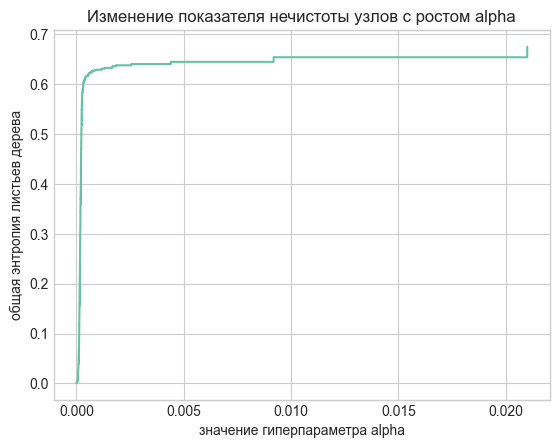

In [25]:
# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker=',', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [26]:
# обучающая и тестовая выборки, чтобы сэкономить время
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=my_seed)

# модели
clfs = list()

# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 731.21 секунд


In [27]:
# извлекаем характеристики глубины и точности
#  таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
#  таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 14.00 секунд


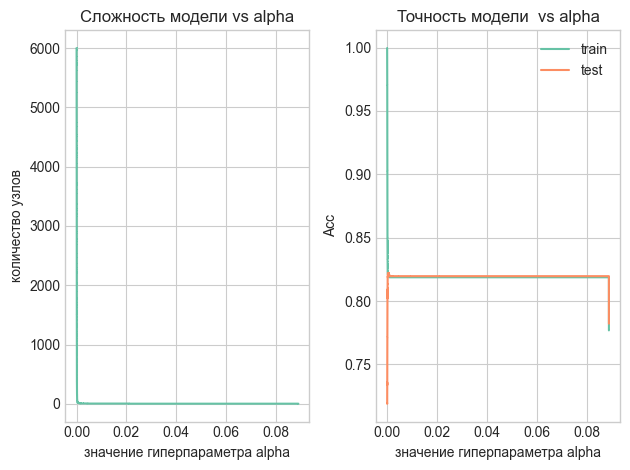

In [28]:
# изображаем на графике
fig, ax = plt.subplots(1, 2)

# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")

# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train',
           drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test',
           drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели  vs alpha")
ax[1].legend()
fig.tight_layout()

Находим оптимальный размер дерева по максимуму $Acc$ на тестовой выборке.  

In [29]:
# оптимальное количество узлов
opt_nodes_num = node_counts[test_scores.index(max(test_scores))]

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=clfs[opt_nodes_num], X=X, y=y, cv=5,
                    scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('pruned_tree')

print('Оптимальное количество узлов:', opt_nodes_num,
      '\nсоответствующая Acc на тестовой:', np.around(max(test_scores), 3),
      '\n\nAcc с перекрёстной проверкой',
      '\nдля модели', score_models[1], ':', score[1])

Оптимальное количество узлов: 33 
соответствующая Acc на тестовой: 0.822 

Acc с перекрёстной проверкой 
для модели pruned_tree : 0.737


Посмотрим на характеристики глубины и сложности построенного дерева с обрезкой ветвей.

In [30]:
# выводим количество листьев (количество узлов)
clfs[opt_nodes_num].get_n_leaves()

2249

In [31]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
clfs[opt_nodes_num].get_depth()

39

---

📚 **Пример визуализации небольшого дерева**

Лучшее дерево с обрезкой по-прежнему слишком велико для визуализации. Для примера нарисуем одно из небольших деревьев с обрезкой и выведем его же в виде текста.  

In [32]:
# находим деревья с количеством листьев меньше 20
[i for i in node_counts if i < 20]

[19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 17,
 17,
 17,
 17,
 17,
 17,
 13,
 9,
 9,
 9,
 7,
 7,
 7,
 5,
 5,
 3,
 1]

In [33]:
plot_tree?

Количество узлов: 19 
Точность дерева на тестовой: 0.822


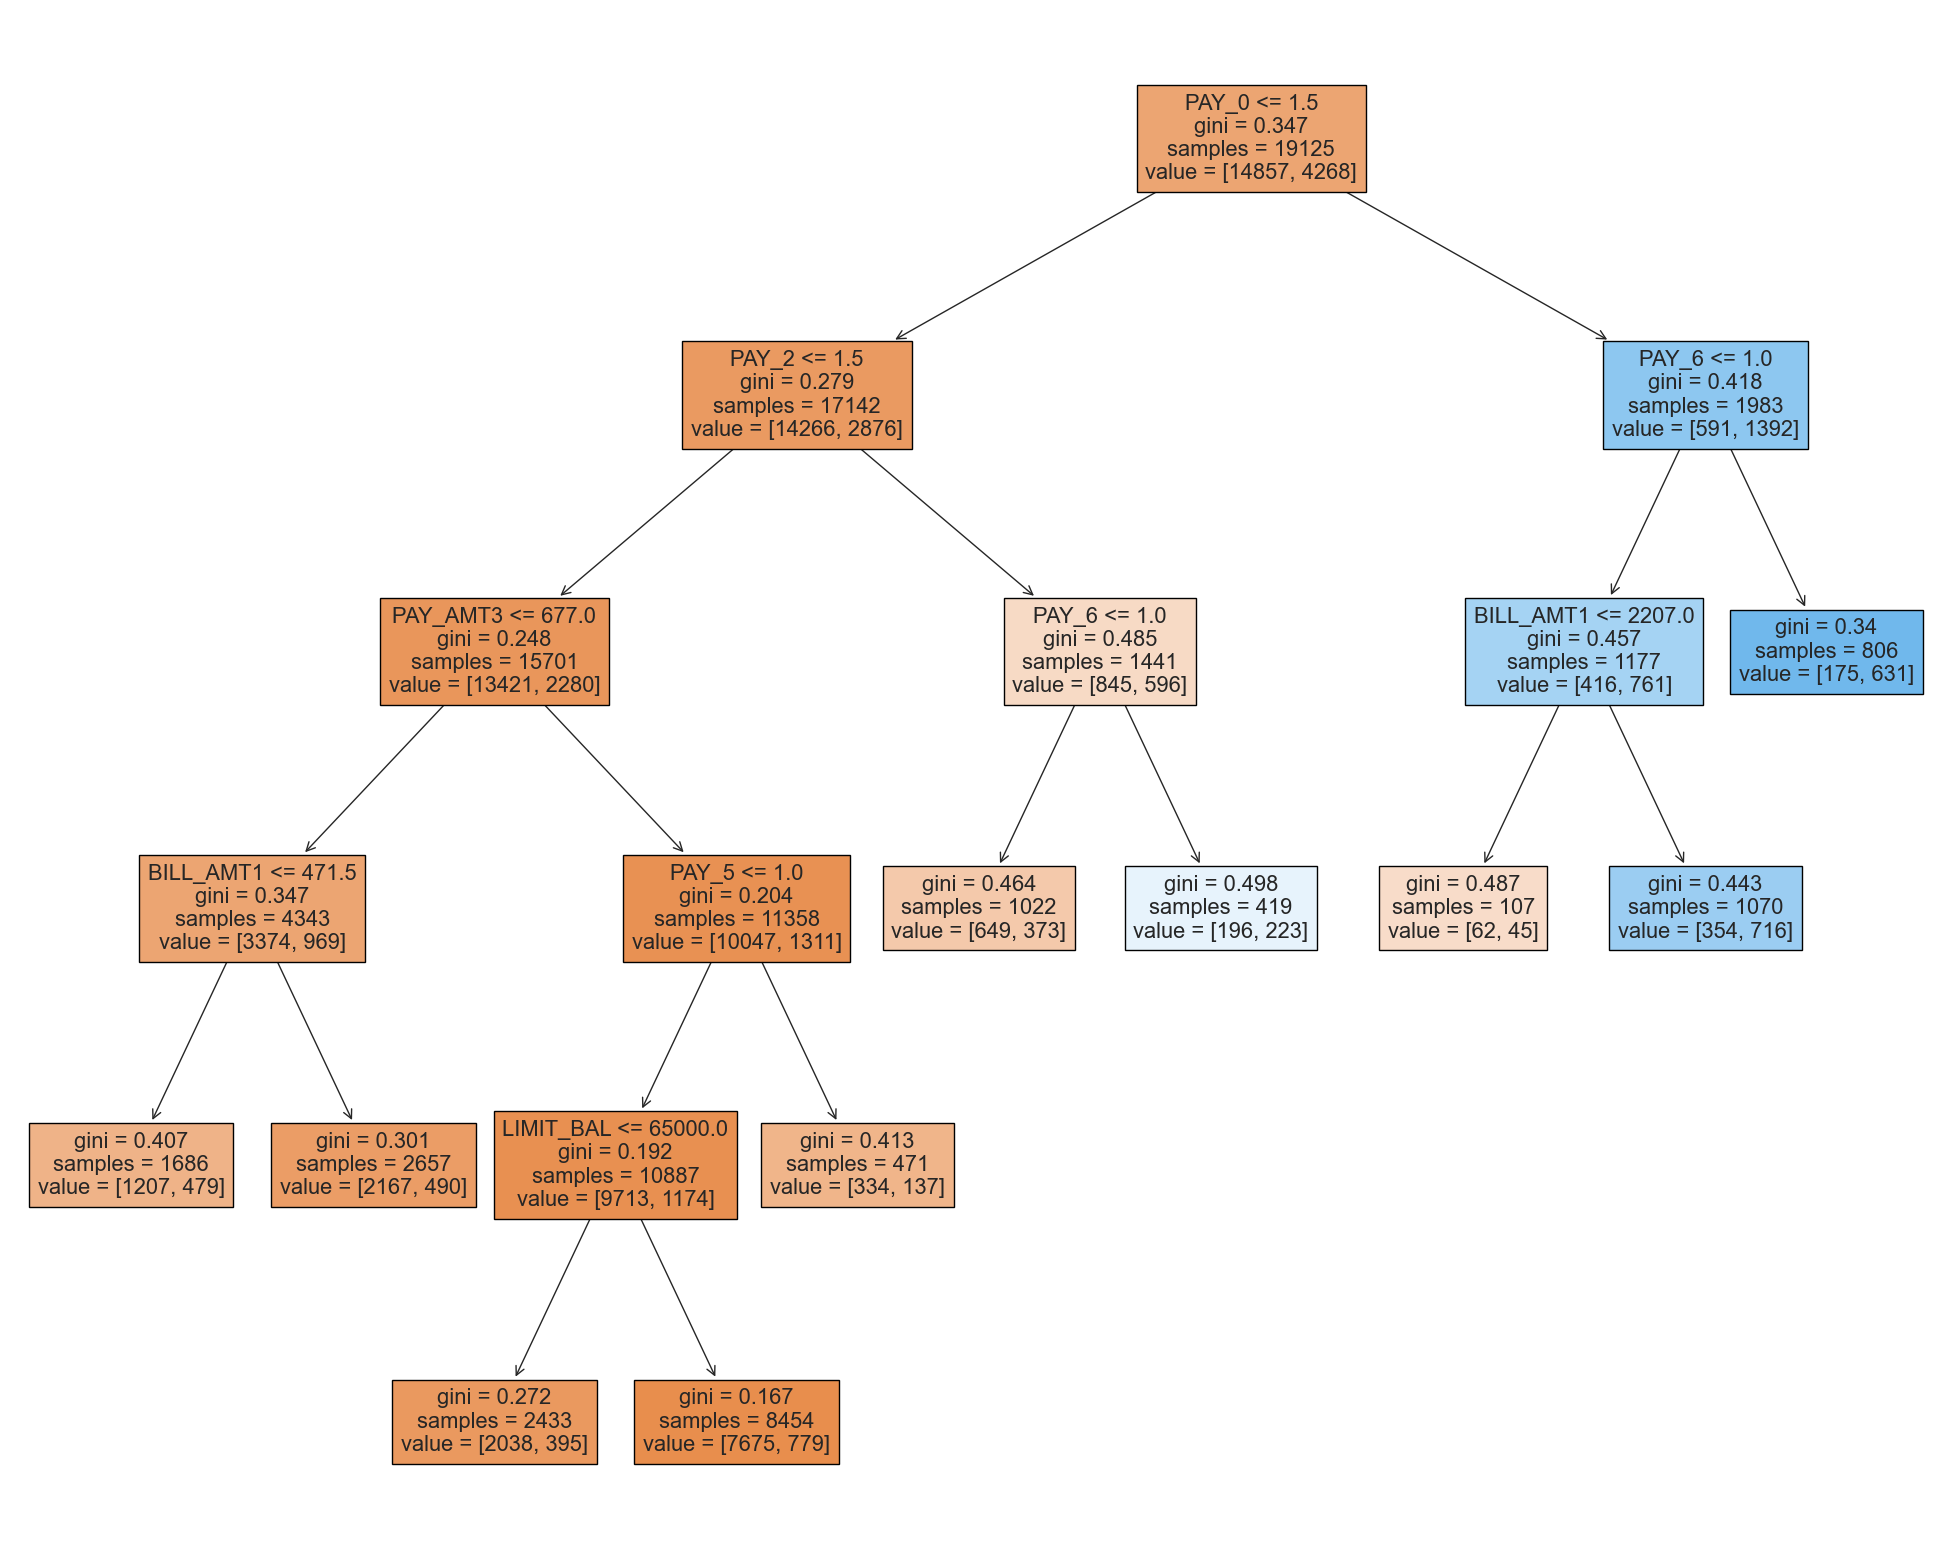

In [34]:
# визуализация на схеме НА ПРИМЕРЕ МАЛЕНЬКОГО ДЕРЕВА
nodes_num = 19
print('Количество узлов:', nodes_num,
      '\nТочность дерева на тестовой:', 
      np.around(test_scores[node_counts.index(nodes_num)], 3))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clfs[node_counts.index(nodes_num)], 
              filled=True, 
              feature_names=list(X.columns))

In [35]:
# визуализируем дерево в виде текстовой схемы
viz = export_text(clfs[node_counts.index(nodes_num)], 
                  feature_names=list(X.columns))
print(viz)

|--- PAY_0 <= 1.50
|   |--- PAY_2 <= 1.50
|   |   |--- PAY_AMT3 <= 677.00
|   |   |   |--- BILL_AMT1 <= 471.50
|   |   |   |   |--- class: 0
|   |   |   |--- BILL_AMT1 >  471.50
|   |   |   |   |--- class: 0
|   |   |--- PAY_AMT3 >  677.00
|   |   |   |--- PAY_5 <= 1.00
|   |   |   |   |--- LIMIT_BAL <= 65000.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- LIMIT_BAL >  65000.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- PAY_5 >  1.00
|   |   |   |   |--- class: 0
|   |--- PAY_2 >  1.50
|   |   |--- PAY_6 <= 1.00
|   |   |   |--- class: 0
|   |   |--- PAY_6 >  1.00
|   |   |   |--- class: 1
|--- PAY_0 >  1.50
|   |--- PAY_6 <= 1.00
|   |   |--- BILL_AMT1 <= 2207.00
|   |   |   |--- class: 0
|   |   |--- BILL_AMT1 >  2207.00
|   |   |   |--- class: 1
|   |--- PAY_6 >  1.00
|   |   |--- class: 1



# Бустинг 

Подберём сеточным поиском настроечные параметры модели:  
* $B$ число деревьев, 
* $\lambda$ – скорость обучения,
* $d$ – глубина взаимодействия предикторов.

In [36]:
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)
# обучаем модель с параметрами по умолчанию
clf_tst = GradientBoostingClassifier(n_estimators=100, learning_rate=1,
                                    max_depth=1, random_state=my_seed)
cv = cross_val_score(clf_tst, X, y, cv=kfold, scoring='accuracy')
np.around(np.mean(cv), 3)

0.818

In [37]:
# настроим параметры бустинга с помощью сеточного поиска
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70],
              'learning_rate' : np.linspace(start=0.01, stop=0.25, num=15),
              'max_depth' : [1, 2]}

# таймер
tic = time.perf_counter()
clf = GridSearchCV(GradientBoostingClassifier(),
                   param_grid, scoring='accuracy', cv=kfold)
boost_tree = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 1676.04 секунд


In [38]:
# точность лучшей модели
np.around(boost_tree.best_score_, 3)

0.822

In [39]:
# параметры лучшей модели
print('n_estimators:', 
      boost_tree.best_estimator_.get_params()['n_estimators'],
      '\nlearning_rate:',
      boost_tree.best_estimator_.get_params()['learning_rate'],
      '\nmax_depth:',
      boost_tree.best_estimator_.get_params()['max_depth'])

n_estimators: 60 
learning_rate: 0.11285714285714286 
max_depth: 2


In [40]:
# записываем точность
score.append(np.around(boost_tree.best_score_, 3))
score_models.append('boost_tree_GS')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[3], ':', score[3])

IndexError: list index out of range


# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [ ]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

Все модели показывают среднюю точность по показателю $Acc$, при этом самой точной оказывается модель бустинга. Сделаем прогноз на отложенные наблюдения.   

In [ ]:
# данные для прогноза
X_pred = DF_predict_num.drop(['Y'], axis=1)
# строим прогноз
y_hat = boost_tree.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict_num['Y'], y_hat))